In [1]:
%cd ..

/home/wiss/hofherrf/gitRepos/pendulum_2d


In [2]:
import os
import yaml
import torch
from torchvision import utils
from models.sceneRepresentation import Scene
from dataset.dataset import ImageDataset_paig
from util.util import compute_psnr
import matplotlib.pyplot as plt

## Quantitative evaluation

In [7]:
error_threshold = 1001

path_experiments = os.path.join(
    os.path.abspath(''),
    'experiments',
    '2023-01-24',
    'Spring'
)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

param_errors = []
psnrs = []
failure_cases = 0
path_file = os.path.join(path_experiments, 'results.txt')

# Delete previous result files
if os.path.exists(path_file):
    os.remove(path_file)

# Get all the experiments
for path_experiment in os.scandir(path_experiments):
    # Load Config
    path_conf = os.path.join(path_experiment, '.hydra','config.yaml')
    with open(path_conf) as f:
        cfg = yaml.safe_load(f)

    print("Doing batch_idx: ", cfg['data']['batch_idx'])

    # Load Model
    model = Scene(**cfg['scene']['background'])

    model.add_2ObjectsSpring(
        **cfg['scene']['local_representation']
    )

    path_ckpt = os.path.join(path_experiment, 'ckpt.pth')
    model.load_state_dict(torch.load(path_ckpt))

    model.to(device)

    # Load Data
    data_path = os.path.join(os.path.abspath(''), 'data',cfg['data']['path_data'])

    data = ImageDataset_paig(
            path_data=data_path,
            batch_idx=cfg['data']['batch_idx'],
            use_subsampling=False,
        )
    H, W = data.get_image_dim()

    # Compute Parameter Errors
    true_k = 2.0
    true_l = 12.0
    rel_error_k = torch.abs(true_k - model.local_representation.ode.k.data) / true_k
    rel_error_l = torch.abs(true_l - W*model.local_representation.ode.eq_distance.data) / true_l

    # Compute PSNR and IoU
    tspan = data.t_steps.to(device)
    model.update_trafo(tspan)
    output = model.render_image(W, H)
    psnr = compute_psnr(output['Image'].cpu(), data.get_full_images())

    # Write summary file
    with open(path_file, 'a') as f:
        f.write(f"Batch idx: {cfg['data']['batch_idx']}\n")
        f.write(f"{path_experiment.path}\n")
        f.write(f"Rel Error k: {rel_error_k}\n")
        f.write(f"Rel Error l: {rel_error_l.data}\n")
        f.write(f"PSNR: {psnr}\n")

        if torch.max(torch.stack([rel_error_k, rel_error_l])) < error_threshold:
            param_errors.append(rel_error_k)
            param_errors.append(rel_error_l)
            psnrs.append(psnr)
        else:
            failure_cases += 1
            f.write("NOT INCLUDED IN AVERAGE\n")

        f.write("=============================\n\n")

    mean_errors = torch.mean(torch.tensor([rel_error_k, rel_error_l]))
    print(f"Mean Errors: {mean_errors}, PSNR: {psnr}")

    print("Done")
    print("====================================================")

avg_param_error = torch.mean(torch.tensor(param_errors))
median_param_error = torch.median(torch.tensor(param_errors))
avg_psnr = torch.mean(torch.tensor(psnrs))
print("Results:")
print(f"Avg Param Error: {avg_param_error}, Median Param Error: {median_param_error} Avg PSNR: {avg_psnr}, Failure Cases: {failure_cases}")

# Write to results file
with open(path_file, 'a') as f:
    f.write("\nLatex\n")
    f.write(f"{avg_psnr:.2f} & {(100*avg_param_error):.2f} & {(100*median_param_error):.2f}")

Doing batch_idx:  7
Mean Errors: 0.007938861846923828, PSNR: 32.975128173828125
Done
Doing batch_idx:  0
Mean Errors: 0.004327218048274517, PSNR: 34.292240142822266
Done
Doing batch_idx:  1
Mean Errors: 0.026953857392072678, PSNR: 31.14952278137207
Done
Doing batch_idx:  6
Mean Errors: 0.006293197628110647, PSNR: 30.198944091796875
Done
Doing batch_idx:  9
Mean Errors: 0.023530662059783936, PSNR: 28.577655792236328
Done
Doing batch_idx:  4
Mean Errors: 0.06360620260238647, PSNR: 27.39082145690918
Done
Doing batch_idx:  2
Mean Errors: 0.06974134594202042, PSNR: 30.561641693115234
Done
Doing batch_idx:  8
Mean Errors: 0.02963550016283989, PSNR: 25.000171661376953
Done
Doing batch_idx:  3
Mean Errors: 0.0019450982799753547, PSNR: 31.839107513427734
Done
Doing batch_idx:  5
Mean Errors: 0.008500337600708008, PSNR: 29.83641815185547
Done
Results:
Avg Param Error: 0.02424722909927368, Median Param Error: 0.008599519729614258 Avg PSNR: 30.182165145874023, Failure Cases: 0


## Render images

Moved to device


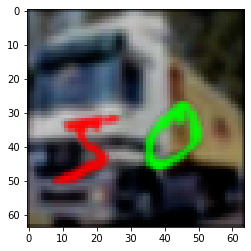

PSNR:  tensor(34.2922)
Error k:  tensor(0.0024, device='cuda:0')
Error l:  tensor(0.0063, device='cuda:0')


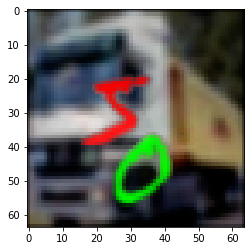

In [10]:
path_experiment = os.path.join(
    os.path.abspath(''),
    'experiments',
    '2023-01-24',
    'Spring',
    '09-45-53_seq0'
)

path_conf = os.path.join(path_experiment, '.hydra','config.yaml')
with open(path_conf) as f:
    cfg = yaml.safe_load(f)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

model = Scene(**cfg['scene']['background'])

model.add_2ObjectsSpring(
    **cfg['scene']['local_representation']
)

path_ckpt = os.path.join(path_experiment, 'ckpt.pth')
model.load_state_dict(torch.load(path_ckpt))

model.to(device)
print("Moved to device")

data_path = os.path.join(os.path.abspath(''), 'data',cfg['data']['path_data'])

render_dataset = ImageDataset_paig(
        path_data=data_path,
        batch_idx=cfg['data']['batch_idx'],
    )

tspan_render = render_dataset.t_steps.to(device)

model.eval()
model.update_trafo(tspan_render)
H, W = render_dataset.get_image_dim()
output = model.render_image(W, H)
ims = output["Image"].cpu()

plt.imshow(ims[0].cpu().numpy())
plt.show()
plt.imshow(ims[25].cpu().numpy())

path_folder_rendering = os.path.join(path_experiment, 'renderings')
os.makedirs(path_folder_rendering)

# Save individual images
for i in range(len(tspan_render)):
    path = os.path.join(path_folder_rendering, f"{i:02}_ours.jpg")
    cur_im = ims[i].permute(2, 0, 1)
    utils.save_image(cur_im, path)

    path = os.path.join(path_folder_rendering, f"{i:02}_gt.jpg")
    cur_im_gt = render_dataset.get_full_images(i).permute(2, 0, 1)
    # utils.save_image(cur_im_gt, path)


print("PSNR: ", compute_psnr(ims, render_dataset.get_full_images()))
print("Error k: ", torch.abs(2.0 - model.local_representation.ode.k.data) / 2.0)
print("Error l: ", torch.abs(12.0 - W*model.local_representation.ode.eq_distance.data) / 12.0)

## Create initialization masks

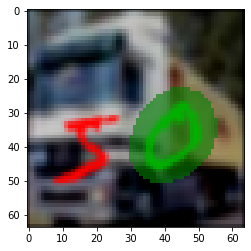

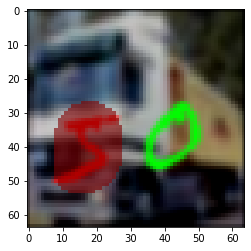

In [11]:
ims = render_dataset.get_full_images(0)
masks = render_dataset.get_full_mask(0)

blend = torch.tensor([0., 0.5, 0.]).unsqueeze(0).unsqueeze(0).repeat(ims.shape[0], ims.shape[1], 1)
mask = masks['masks1'].float().unsqueeze(-1) * 0.6
blended = mask*blend + (1-mask)*ims
plt.imshow(blended)
plt.show()

path = os.path.join(path_folder_rendering, f"init1.jpg")
utils.save_image(blended.permute(2, 0, 1), path)

blend = torch.tensor([0.5, 0., 0.]).unsqueeze(0).unsqueeze(0).repeat(ims.shape[0], ims.shape[1], 1)
mask = masks['masks2'].float().unsqueeze(-1) * 0.6
blended = mask*blend + (1-mask)*ims
plt.imshow(blended)
path = os.path.join(path_folder_rendering, f"init2.jpg")
utils.save_image(blended.permute(2, 0, 1), path)